In [83]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn.functional as F
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings("ignore")

### Data Loading

In [84]:
data_ = pd.read_csv("../data/FilteredData.csv")

In [85]:
def SingleAtomRemover(x):
    singleAtom = ["[Kr]","[Ne]","C","[Li]","O","[Ar]",'[Xe]']
    if x in singleAtom:
        return 1
    else: 
        return 0  

In [86]:
data = data_[["Structure","BBB+/BBB-"]]

In [87]:
data.replace({"BBB+":1,"BBB-":0},inplace=True)

In [88]:
data.rename(columns={"Structure":"SMILES","BBB+/BBB-":"LABELS"},inplace=True)

In [89]:
data["Isit"] = data["SMILES"].apply(SingleAtomRemover)

In [90]:
### Remove single element
data.drop(data[data["Isit"] == 1].index,inplace=True)

In [91]:
data.to_csv(r"raw/data.csv")

In [92]:
from torch_geometric.data import InMemoryDataset, download_url, Dataset, Data
from rdkit import Chem

class BBBDataset(Dataset): ### All dataset will store in RAM
    
    def __init__(self,root,transform = None, pre_transform=None,pre_filter=None):
        
        """
        root: where the dataset shoul be stored. The folder will split into raw_dir (downloaded dataset)
        and processed_dir (processed data).

        """
        super().__init__(root, transform, pre_transform, pre_filter)
    
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "data.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        dataArray = self.data[["SMILES","LABELS"]].to_numpy().squeeze()
        
        j = 0
        for i in tqdm(dataArray):
            processed_data = self.smiles2graph(*i)
            
            nodes_feats = processed_data["X"]
            label = processed_data["Y"]
            edge_feats = processed_data["E"]
            adj_mat = processed_data["A"]
            smiles = processed_data["SMILES"]
            
            
            ### create data object
            data = Data(x=nodes_feats,edge_index=adj_mat,edge_attr=edge_feats,y=label,smiles=smiles)
            
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def smiles2graph(self, smiles,label):
        try:
            mol = Chem.MolFromSmiles(smiles)
        except:
            raise("Smiles not parsed by rdkit")

        adj_matrix = GetAdjacencyMatrix(mol) ### Adjacency matrix
        row,col = np.where(adj_matrix)
        coo = np.array(list(zip(row,col)))
        coo = np.reshape(coo,(2,-1))

        feature_array = np.zeros((mol.GetNumAtoms(),5),) ### Feature Matrix
        for idx,atom in enumerate(mol.GetAtoms()):
            feature_array[idx,0] = atom.GetAtomicNum()
            feature_array[idx,1] = atom.GetDegree()
            #feature_array[idx,2] = atom.GetFormalCharge()
            feature_array[idx,2] = atom.GetHybridization()
            feature_array[idx,3] = atom.GetExplicitValence()
            feature_array[idx,4] = atom.GetMass()
           
        label_array = torch.tensor([0]) if label == 0 else torch.tensor([1])
        
#         if label == 0:
#             label_array = torch.tensor([0])
#         else:
#             label_array = torch.tensor([1])

        all_edge_feats = []
        for bond in mol.GetBonds():
            Edge_feature = []
            # Feature 1: Bond type (as double)
            Edge_feature.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            Edge_feature.append(bond.IsInRing())
            # Append edget features to matrix (twice, per direction)
            all_edge_feats += [Edge_feature, Edge_feature]

        all_edge_feats = np.asarray(all_edge_feats)

        return {"A": torch.tensor(coo,dtype=torch.long),
               "X": torch.tensor(feature_array,dtype=torch.float32),
               "Y":torch.tensor(label_array,dtype=torch.float32),
                "E":torch.tensor(all_edge_feats,dtype=torch.float32),
                "SMILES":smiles}
    
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data


In [93]:
dataset = BBBDataset(root=".")

Processing...
100%|█████████████████████████████████████████████████████████████████████████████| 3330/3330 [00:04<00:00, 736.70it/s]
Done!


### Applying PyG GCN
___

In [94]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [97]:
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

class PyGCN(torch.nn.Module):
    
    def __init__(self,num_node_features):
        
        super().__init__()
        self.num_node_features = num_node_features ### Node input size
        
        self.conv_1 = GCNConv(self.num_node_features,64,improved=True) ### First layer convulation
        self.conv_2 = GCNConv(64,32) ### Second layer convulation
        self.conv_3 = GCNConv(32,16) ### Third layer convulation
        
        ## Two linear layer
        self.fc_1  = Linear(16,8)
        self.fc_2  = Linear(8,1)
       
            
    def forward(self,data,):
        
        batch, x,edge_index,edge_attr,y,smiles  = data.batch, data.x, data.edge_index, data.edge_attr,data.y, data.smiles
        
        ## Graph convulations
        x = F.relu(self.conv_1(x,edge_index)) 
        x = F.relu(self.conv_2(x,edge_index))
        x = F.relu(self.conv_3(x,edge_index))
        ## Readout layer
        x = global_mean_pool(x,batch)
        
        ### Final classifier
        x = F.relu(self.fc_1(x))
        x = F.sigmoid(self.fc_2(x))
    
        
        return x        

In [98]:
from torch.utils.data import random_split
### Splitting of data
train_set, valid_set, test_set = random_split(dataset,[2800,300,230])
trainloader = DataLoader(train_set,shuffle=True,batch_size=32)
validloader = DataLoader(valid_set, shuffle=True,batch_size=32)
testloader = DataLoader(test_set, shuffle=True,batch_size=32)

In [99]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax

## Intilaize Network
net = PyGCN(num_node_features=5)

### initialize an optimizer with someparameters
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001,momentum=0.9,)

### Defining loss
criterion = BCELoss()

### criterion
criterion.cuda()

## shifting to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

PyGCN(
  (conv_1): GCNConv(5, 64)
  (conv_2): GCNConv(64, 32)
  (conv_3): GCNConv(32, 16)
  (fc_1): Linear(in_features=16, out_features=8, bias=True)
  (fc_2): Linear(in_features=8, out_features=1, bias=True)
)

In [100]:
def train():
    net.train()
    train_loss = []
    for data in trainloader:## Iterate in batches over training dataset
        data.to(device)
        optimizer.zero_grad() ## clear gradients
        out = net(data).squeeze(0) ## single forward pass
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        train_loss.append(loss)
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
    return torch.sum(torch.tensor(train_loss))/len(trainloader)
        
        

In [101]:
def test(loader):
    net.eval()
    val_loss = []
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        out = net(data).squeeze(0) ## single forward pass
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
    return torch.sum(torch.tensor(val_loss))/len(loader)

In [102]:
epochs = 50
epoch_loss = []
valida_loss = []
test_loss = []
for epoch in range(1,epochs):
    train_loss = train()
    train_acc = test(trainloader)
    val_acc = test(validloader)
    test_acc = test(testloader)
    epoch_loss.append(train_loss)
    valida_loss.append(val_acc)
    test_loss.append(test_acc)
    #print(train_loss)
    print(f'Epoch: {epoch:03d}, Train loss: {train_acc:.4f}, val loss: {val_acc:.4f},test loss: {test_acc:.4f}')

Epoch: 001, Train loss: 0.6686, val loss: 0.6657,test loss: 0.6753
Epoch: 002, Train loss: 0.6684, val loss: 0.6658,test loss: 0.6748
Epoch: 003, Train loss: 0.6681, val loss: 0.6659,test loss: 0.6747
Epoch: 004, Train loss: 0.6682, val loss: 0.6633,test loss: 0.6828
Epoch: 005, Train loss: 0.6687, val loss: 0.6634,test loss: 0.6750
Epoch: 006, Train loss: 0.6685, val loss: 0.6705,test loss: 0.6883
Epoch: 007, Train loss: 0.6684, val loss: 0.6704,test loss: 0.6817
Epoch: 008, Train loss: 0.6686, val loss: 0.6682,test loss: 0.6746
Epoch: 009, Train loss: 0.6683, val loss: 0.6681,test loss: 0.6910
Epoch: 010, Train loss: 0.6684, val loss: 0.6634,test loss: 0.6826
Epoch: 011, Train loss: 0.6690, val loss: 0.6573,test loss: 0.6817
Epoch: 012, Train loss: 0.6686, val loss: 0.6633,test loss: 0.6909
Epoch: 013, Train loss: 0.6681, val loss: 0.6657,test loss: 0.6904
Epoch: 014, Train loss: 0.6690, val loss: 0.6657,test loss: 0.6827
Epoch: 015, Train loss: 0.6684, val loss: 0.6681,test loss: 0.

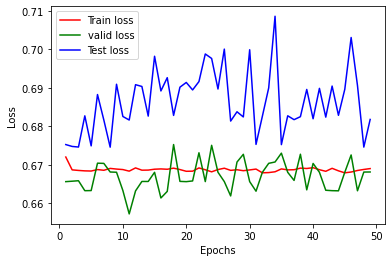

In [105]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,50)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,50)],[i.cpu().detach().numpy() for i in valida_loss],label="valid loss",color="Green")
plt.plot([i for i in range(1,50)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [106]:
print(f"Training loss:   Mean: {torch.tensor(epoch_loss).mean()}   std: {torch.tensor(epoch_loss).std()}")
print(f"validation loss: Mean: {torch.tensor(valida_loss).mean()}   std: {torch.tensor(valida_loss).std()}")
print(f"Test loss:       Mean: {torch.tensor(test_loss).mean()}   std: {torch.tensor(test_loss).std()}")

Training loss:   Mean: 0.6687827110290527   std: 0.0005876418435946107
validation loss: Mean: 0.6670528054237366   std: 0.003856704570353031
Test loss:       Mean: 0.6865770816802979   std: 0.008122407831251621
